# Implement Support Vector Machines in scikit-learn

- toc:true
- badges: true
- comments: true
- author: Pushkar G. Ghanekar
- categories: [python, machine-learning]

This tutorial is borrowed from Jake VanderPlas's example of SVM in his notebook: [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)

## Motivation for Support Vector Machines 

- We want to find a line/curve (in 2D) or a manifold (in n-D) that divides the class from each other. This is a type of _Discriminative Classification_
- Consider a simple case of classification task, in which the two classes of points are well separated

In [1]:
#importing necessary modules
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import stats 
random_state = 42 
#Using seaborn plotting defaults 
import seaborn as sns; sns.set() 

X is a (200, 2) array with x-y coordinates of the cluster points

[[2.24823735 1.07410715]
 [5.12395668 0.73232327]
 [4.6766441  2.72016712]]


y is a (200,) array with a classification of the points to which cluster they belong to

[1 1 1]




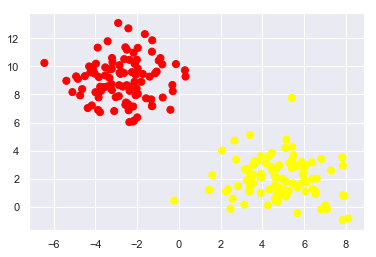

In [2]:
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=200, centers=2, 
                 random_state=random_state,
                 cluster_std=1.5)

#---Check what is X and y ----# 
print('X is a {} array with x-y coordinates of the cluster points\n'.format(np.shape(X)))
print(X[:3])
print('\n')
print('y is a {} array with a classification of the points to which cluster they belong to\n'.format(np.shape(y)))
print(y[:3])
print('\n')
plt.scatter(X[:,0],X[:,1], c=y, s=50, cmap='autumn')

A linear discriminative classifier would attempt to draw a straight line separating the two data-sets and thereby creating a model for classification. For the 2D data like the shown above, this task could be done by hand. But there is more than one line that can divide this data in two halves!

(-0.9549620153430207, 13.094539878082749)

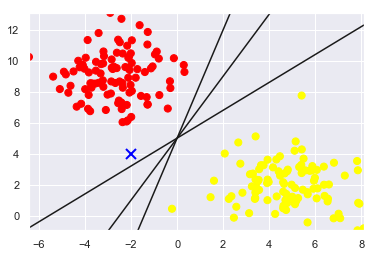

In [3]:
x_fit = np.linspace(min(X[:,0]),max(X[:,0]))
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='autumn')
plt.plot([-2],[4],'x',color='blue', markeredgewidth=2, markersize=10)

for m,b in [(3.5,5),(2,5),(0.9,5)]:
    plt.plot(x_fit, x_fit*m+b, '-k')
    
plt.xlim(min(X[:,0]),max(X[:,0]))
plt.ylim(min(X[:,1]),max(X[:,1]))

What's a better methodology to determine the cutting plane? Something like k-nearest neighbor clustering wherein you find the plane with best separation from the two clusters based on some distance metric. However, k-nearest neighbors is based on non-parametric method of finding the cluster and classifying the new data-point. What if I want something which is _Learned_ is used as a function every other time

**Support Vector Machines:** 

Rather than simply drawing a zero-width line between classes, we can draw round each line a margin of some width, up to the nearest point. 

(-0.9549620153430207, 13.094539878082749)

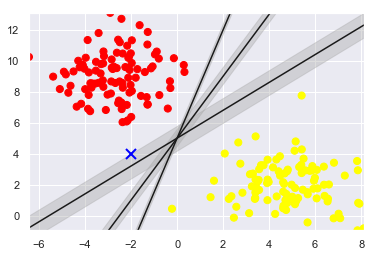

In [4]:
x_fit = np.linspace(min(X[:,0]),max(X[:,0]))
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='autumn')
plt.plot([-2],[4],'x',color='blue', markeredgewidth=2, markersize=10)

for m, b, d in [(3.5,5,0.33),(2,5,0.55),(0.9,5,0.8)]:
    y_fit = x_fit*m + b 
    plt.plot(x_fit, y_fit, '-k')
    plt.fill_between(x_fit, y_fit-d, y_fit+d, edgecolor='none',
                    color='#AAAAAA', alpha=0.4)
    
plt.xlim(min(X[:,0]),max(X[:,0]))
plt.ylim(min(X[:,1]),max(X[:,1]))

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a maximum margin estimator.

### Fitting a support vector machine
Using Scikit-learn's SVM module to train a classifier on the above data. We will use a linear-kernel and set `C` parameters to a very large value. 

In [5]:
from sklearn.svm import SVC
model = SVC(kernel='linear',C=1E10)
model.fit(X,y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

To better visualize the SVM classification, use a convenience function to visualize the decision boundary as made by the SVM module. Code is adopted from Jake's tutorial. 

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True, list_vectors=False):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=100, facecolors='none', edgecolors='black',linestyle='--');
    if list_vectors: 
        print(model.support_vectors_)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

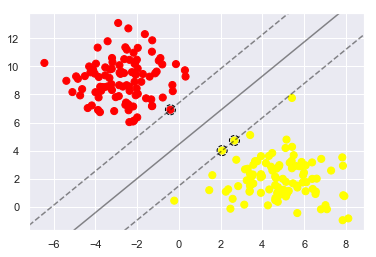

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)

This is the dividing line that maximizes the margin between the two sets of points. 

Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure. 

These points are the __pivotal elements__ of this fit, and are known as the __support vectors__, and give the algorithm its name. 

In Scikit-Learn, the identity of these points are stored in the support_vectors_ attribute of the classifier.

In [8]:
model.support_vectors_

array([[-0.40500616,  6.91150953],
       [ 2.65952903,  4.72035783],
       [ 2.07017704,  4.00397825]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; _**any points further from the margin which are on the correct side do not modify the fit!**_ 

Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

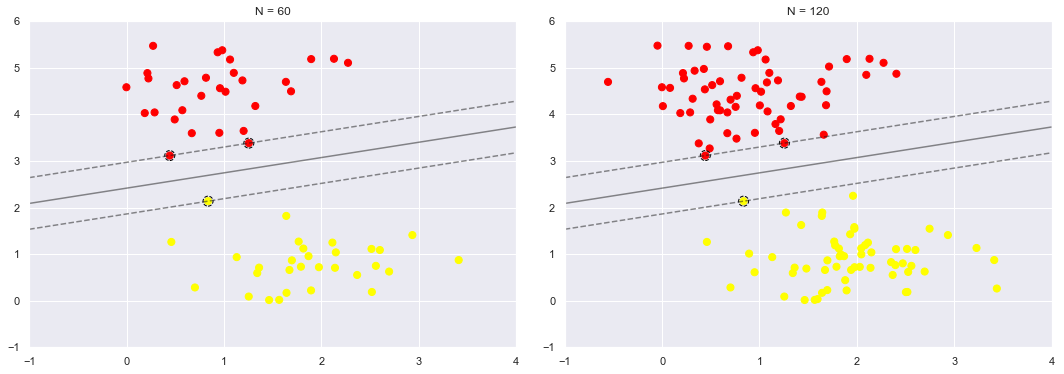

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)
    
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In spite of increasing the training points, once the margins and the corresponding support vectors are identified the model does not change. This is one of the strengths of this algorithm -- the insensitivity to the exact behavior of the distant point is one of the strengths of SVM model 

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 50, 100, 150, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 50, 100, 150, 200), value=10), Output()), _dom_cl…

## Beyond linear kernels: Kernel SVM 

Kernels are helpful in projecting data into higher dimensional feature space. This can be useful in simplest case to fit non-linear data using linear regression models. Similarly in the case of SVM: Projecting the data into higher dimensions through either polynomial or gaussian kernels we can fit non-linear relationships to a linear classifier

Let's look at a data-set which is not linearly separated:

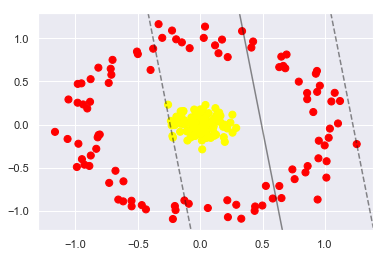

In [11]:
from sklearn.datasets.samples_generator import make_circles

X, y = make_circles(200, factor=0.1, noise=0.1)
clf = SVC(kernel='linear').fit(X,y)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False)

There is not straight forward way to separate this data however we can _project_ the data into higher dimensions based on its properties in the current dimensional space and get more information about its spread. One way of doing so is computing a _radial basis function_ centered at the middle lump

In [12]:
r = np.exp(-(np.sum((X)**2,axis=1)))

from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, -45, -30, 30, 45, 60, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', index=3, options=(-90, -45, -30, 30, 45, 60, 90), value=30)…

Projecting the data in an additonal dimensions we can see can having a plane at r=0.7 could give us good separation. 

Here we had to _choose_ and _carefully tune_ our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results. 

In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

_One strategy to this end is to compute a basis function centered at every point in the dataset, and let the SVM algorithm sift through the results. This type of basis function transformation is known as a kernel transformation, as it is based on a similarity relationship (or kernel) between each pair of points._

A potential problem with this strategy—projecting `N` points into `N` dimensions—is that it might become very computationally intensive as `N` grows large. However, because of a neat little procedure known as the kernel trick, a fit on kernel-transformed data can be done implicitly—that is, without ever building the full `N`-dimensional representation of the kernel projection! This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the kernel model hyperparameter:

In [13]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

/Users/pghaneka/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

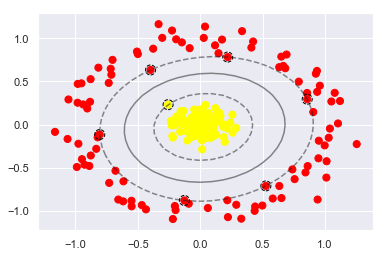

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

## Softer margins

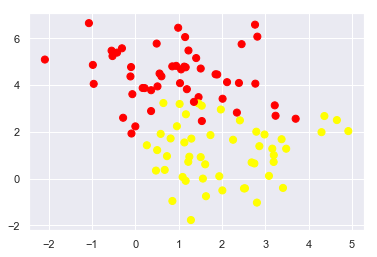

In [15]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit. The hardness of the margin is controlled by a tuning parameter, most often known as `C`. 

__For very large `C`, the margin is hard, and points cannot lie in it. For smaller `C`, the margin is softer, and can grow to encompass some points.__

The plot shown below gives a visual picture of how a changing `C` parameter affects the final fit, via the softening of the margin:

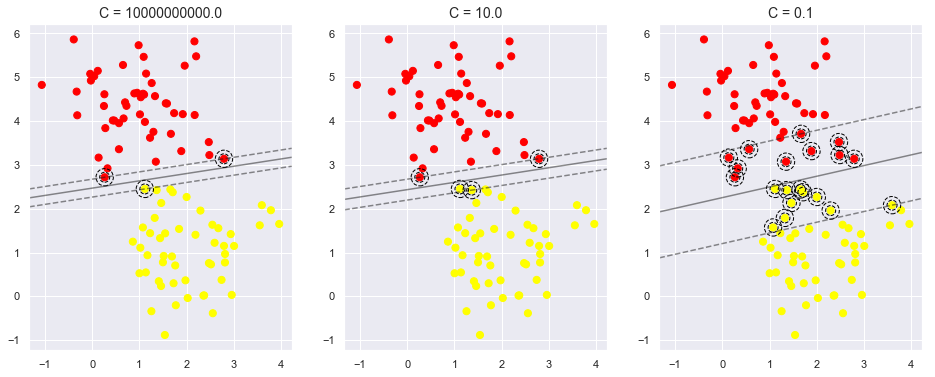

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))

for axi, C in zip(ax, [1E10, 10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, facecolors='none', edgecolors='black',linestyle='--')
    axi.set_title('C = {0:.1f}'.format(C), size=14)

# Example: Facial Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem. We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures. A fetcher for the dataset is built into Scikit-Learn:

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


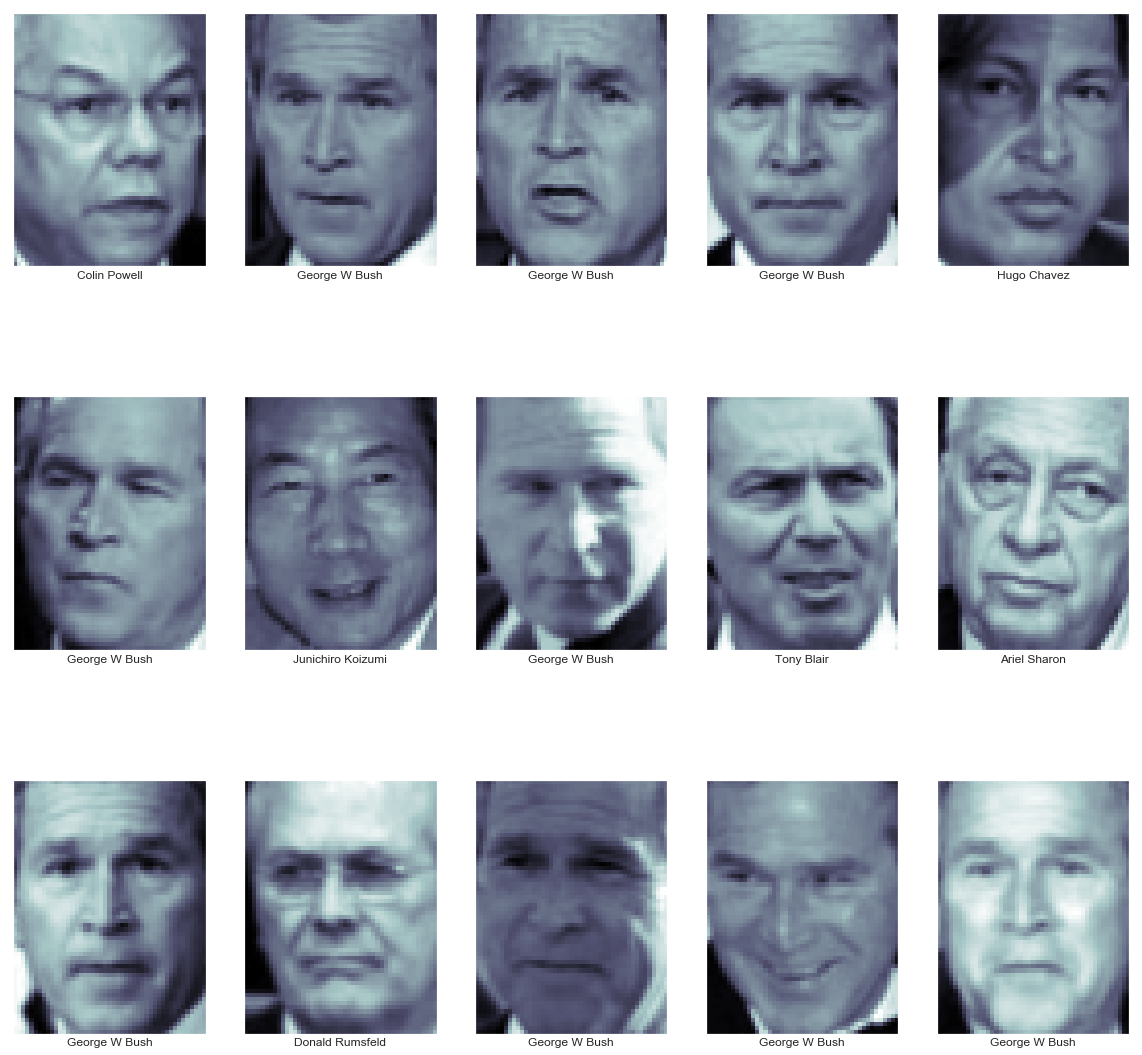

In [18]:
fig, ax = plt.subplots(3,5,figsize=(20,20))
for i,axi in enumerate(ax.flat):
    axi.imshow(faces.images[i],cmap='bone')
    axi.set(xticks=[], yticks=[],
           xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels. We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis to extract 150 fundamental components to feed into our support vector machine classifier. We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [19]:
from sklearn.svm import SVC 
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=0)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca,svc)

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=0)

Finally, we can use a grid search cross-validation to explore combinations of parameters. Here we will adjust C (which controls the margin hardness) and gamma (which controls the size of the radial basis function kernel), and determine the best model:

In [21]:
param_grid = {'svc__C': [0.001, 0.1, 1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, cv=5)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

/Users/pghaneka/miniconda3/envs/py37/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 3min 36s, sys: 15.1 s, total: 3min 51s
Wall time: 48.4 s
{'svc__C': 10, 'svc__gamma': 0.005}


In [22]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

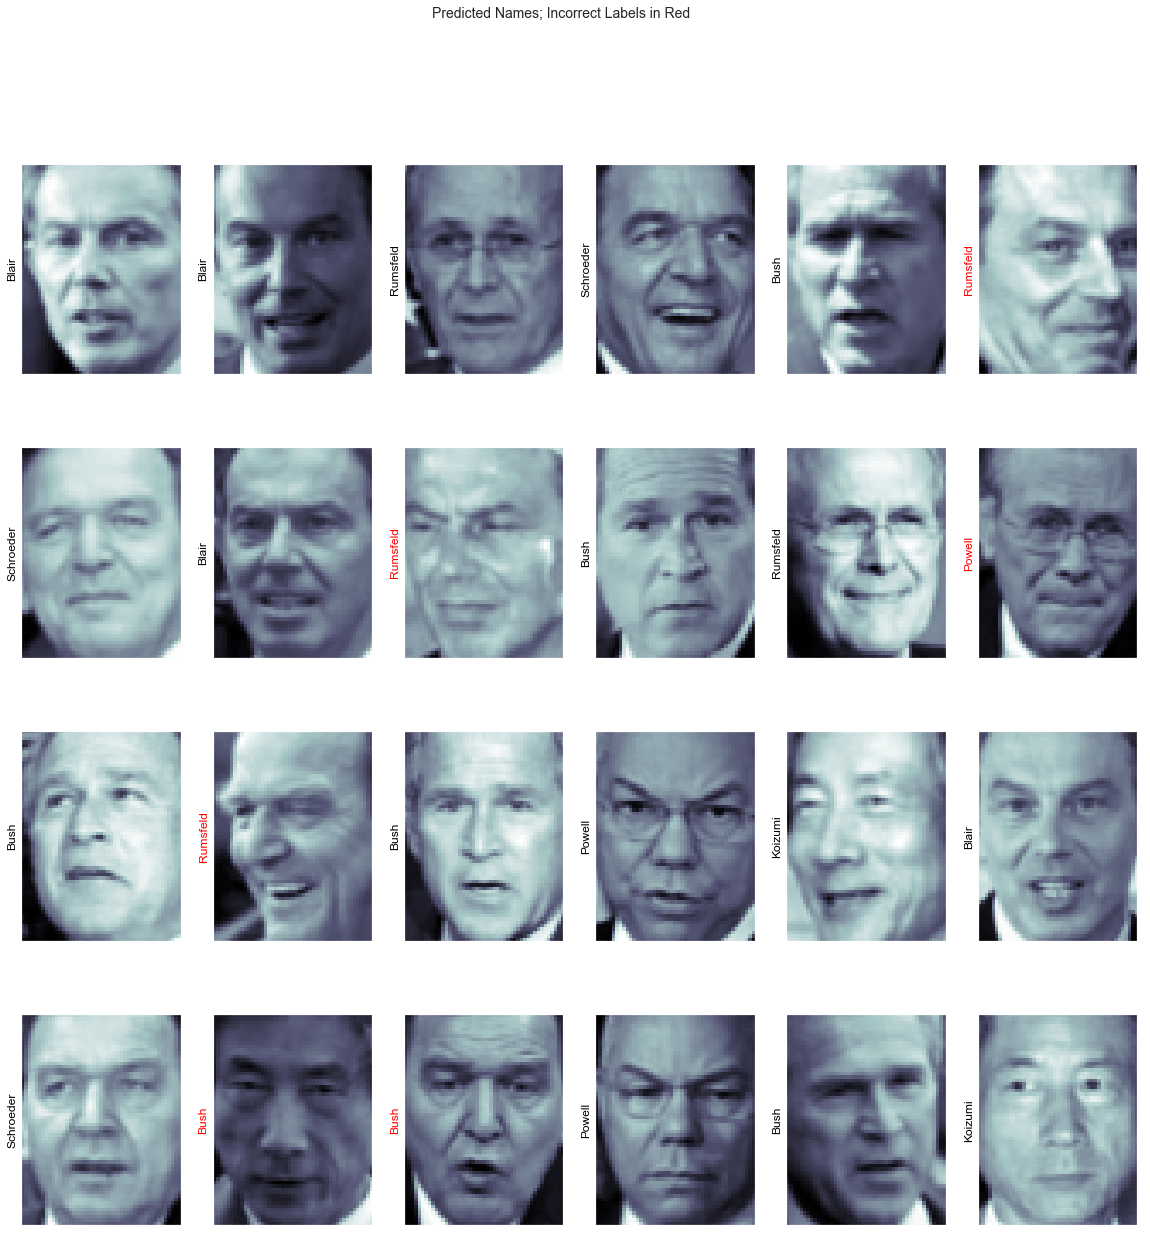

In [23]:
fig, ax = plt.subplots(4, 6,figsize=(20,20))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [24]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.69      0.81        16
     Colin Powell       0.85      0.87      0.86        61
  Donald Rumsfeld       0.75      0.69      0.72        35
    George W Bush       0.78      0.97      0.86       125
Gerhard Schroeder       0.86      0.66      0.75        29
      Hugo Chavez       1.00      0.68      0.81        19
Junichiro Koizumi       1.00      0.76      0.87        17
       Tony Blair       0.93      0.77      0.84        35

         accuracy                           0.83       337
        macro avg       0.90      0.76      0.82       337
     weighted avg       0.85      0.83      0.83       337



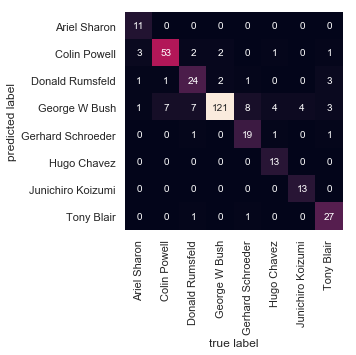

In [25]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');